In [7]:
import sys
sys.path.append("/tf/ProjectGabriel/pilca")



In [8]:
%load_ext autoreload
%autoreload 2


import numpy as np
import pandas as pd
from lightcurve_fitting import models, filters, lightcurve
import matplotlib.pyplot as plt
import matplotlib as mpl
import importlib



from utils.utils import load_lc
from utils.utils import light_curve_plot
import torch
import utils.torchphysics as tp


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
torch.set_default_dtype(torch.float64)


# Building Fake Light Curve

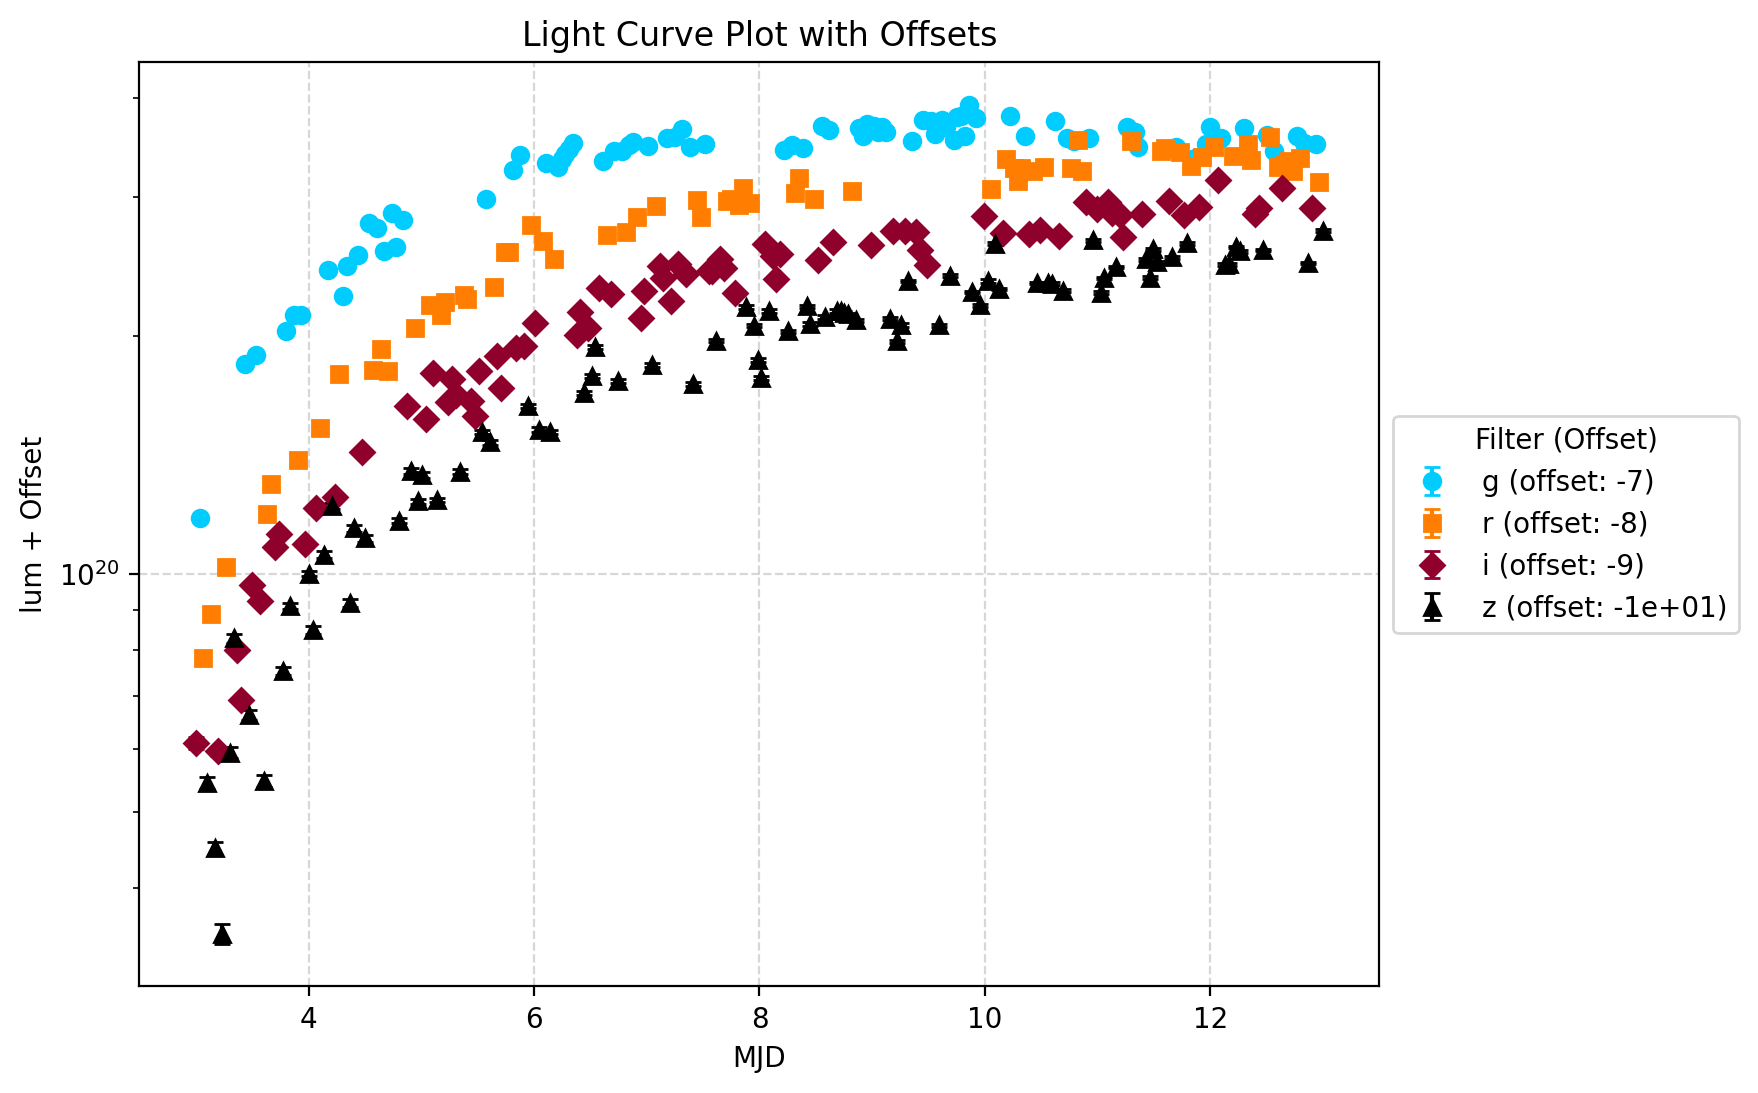

In [10]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model = models.ShockCooling4(lc_fake)


MJD = np.linspace(3, 13, 300)
filters_list = [filters.filtdict["g"], filters.filtdict["r"], filters.filtdict["i"], filters.filtdict["z"]]
filter_for_mjd = np.random.choice(filters_list, size=len(MJD), replace=True)

ten13cmtoRsol = 1/(1e13*1.4374e-11)
ten8p5cmstoten3kms = 1/(10**.5)
units_array = np.array([ten8p5cmstoten3kms, 1, ten13cmtoRsol, 1])
# model_inputs = np.array([7.2, 5, 1.6, 410, 2.5])/units_array
model_inputs = np.array([4, 2, 580, 2.5])*units_array

v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[1]   # Density profile factor
R = model_inputs[2]         # Radius
t_exp = model_inputs[3]     # explosion time
lum = model(MJD, v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd) + np.random.normal(0, 1e19, len(MJD))

lc = load_lc(lc=lightcurve.LC({"MJD":MJD,
                "lum":lum,
                "dlum":np.random.normal(.1e19, .1e18, len(lum)),
                "filter":filter_for_mjd}),
                fake=False)
lc
light_curve_plot(lc, offset = 1)
# aa

In [11]:
lc

MJD,lum,dlum,filter
float64,float64,float64,object
3.0,6.106711213890065e+19,1.0246339936754685e+18,i
3.0334448160535117,1.1761626983884902e+20,1.0406412819514748e+18,g
3.0668896321070234,7.82368078072157e+19,1.0888146914902542e+18,r
3.100334448160535,5.439853331980031e+19,9.570471860591692e+17,z
3.1337792642140467,8.89356922201513e+19,1.1220343270072225e+18,r
3.1672240802675584,4.4919080095864414e+19,8.869805152859386e+17,z
3.20066889632107,5.9597153930811605e+19,8.317549887132728e+17,i
3.234113712374582,3.4969156669126967e+19,1.0272518423229425e+18,z
3.2675585284280935,1.0191278287677596e+20,9.707223370310938e+17,r


In [12]:
np.mean(lum)
# aaa

2.5087850610468867e+20

# Preparing PILCA

In [13]:
MJD_TO_MODEL = MJD
LUM_TO_MODEL = np.log10(lc["lum"])
DLUM_TO_MODEL = lc["dlum"]/lc["lum"]/np.log(10)

X_DATA = np.hstack([MJD_TO_MODEL.reshape(-1,1), LUM_TO_MODEL.reshape(-1,1), DLUM_TO_MODEL.reshape(-1,1)])
ufilters = np.unique(lc["filter"])
filters_mask = torch.zeros((len(ufilters),len(lc)), requires_grad=False, dtype=torch.bool)
for i in range(len(ufilters)):
    filters_mask[i] = torch.tensor(lc["filter"]==ufilters[i])

X_DATA = torch.tensor(X_DATA, requires_grad=False)

In [14]:
filters_mask[0]

tensor([False,  True, False, False, False, False, False, False, False, False,
        False, False, False,  True, False, False,  True, False, False, False,
        False, False, False, False,  True, False,  True, False,  True, False,
        False, False, False, False, False,  True, False, False, False,  True,
         True, False, False,  True, False, False,  True, False,  True, False,
         True, False,  True,  True, False,  True, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False,  True, False, False,
        False, False, False, False,  True, False,  True, False, False, False,
        False, False, False,  True, False, False,  True,  True,  True,  True,
         True, False, False, False, False, False, False, False,  True, False,
        False,  True, False,  True, False,  True,  True, False, False, False,
         True, False, False, False, False,  True, False,  True, 

In [15]:
importlib.reload(models)
lc_fake = load_lc(fake=True)
model_original = models.ShockCooling4(lc_fake)

ten13cmtoRsol = 1e13*1.4374e-11

ten8p5cmstoten3kms = 10**.5
units_array = np.array([ten8p5cmstoten3kms, 1, ten13cmtoRsol, 1])
# model_inputs = #np.array([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01])
v_s = model_inputs[0]       # Shock velocity
M_env = model_inputs[1]     # Envelope mass
f_rho_M = model_inputs[1]   # Density profile factor
R = model_inputs[2]         # Radius
t_exp = model_inputs[3]     # explosion time

lum = model_original(MJD[0:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=[filter_for_mjd[0]])
lum_original = lum
lum[:20]

array([[5.17474026e+19, 5.41586460e+19, 5.65473685e+19, 5.89134261e+19,
        6.12567606e+19, 6.35773815e+19, 6.58753509e+19, 6.81507730e+19,
        7.04037848e+19, 7.26345493e+19, 7.48432500e+19, 7.70300864e+19,
        7.91952704e+19, 8.13390236e+19, 8.34615743e+19, 8.55631563e+19,
        8.76440071e+19, 8.97043662e+19, 9.17444745e+19, 9.37645734e+19,
        9.57649037e+19, 9.77457054e+19, 9.97072169e+19, 1.01649675e+20,
        1.03573314e+20, 1.05478366e+20, 1.07365061e+20, 1.09233624e+20,
        1.11084281e+20, 1.12917251e+20, 1.14732752e+20, 1.16530998e+20,
        1.18312201e+20, 1.20076568e+20, 1.21824305e+20, 1.23555612e+20,
        1.25270689e+20, 1.26969729e+20, 1.28652926e+20, 1.30320467e+20,
        1.31972539e+20, 1.33609325e+20, 1.35231004e+20, 1.36837753e+20,
        1.38429746e+20, 1.40007153e+20, 1.41570144e+20, 1.43118882e+20,
        1.44653532e+20, 1.46174253e+20, 1.47681202e+20, 1.49174535e+20,
        1.50654404e+20, 1.52120958e+20, 1.53574346e+20, 1.550147

In [16]:
importlib.reload(tp)
model_inputs_torch = torch.tensor(model_inputs)#torch.tensor([5.3875e+00, 4.1513e-07, 2.6636e+00, 1.7901e+00, 8.9253e-01], dtype=torch.float64)


v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[1]   # Density profile factor
R = model_inputs_torch[2]         # Radius
t_exp = model_inputs_torch[3]     # explosion time
model_torch = tp.ShockCooling4(z=lc.meta["redshift"])
lum= model_torch(MJD[:], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=filter_for_mjd[0])
lum_torch = lum
lum#[:20]

tensor([5.1747e+19, 5.4159e+19, 5.6547e+19, 5.8913e+19, 6.1257e+19, 6.3577e+19,
        6.5875e+19, 6.8151e+19, 7.0404e+19, 7.2635e+19, 7.4843e+19, 7.7030e+19,
        7.9195e+19, 8.1339e+19, 8.3462e+19, 8.5563e+19, 8.7644e+19, 8.9704e+19,
        9.1744e+19, 9.3765e+19, 9.5765e+19, 9.7746e+19, 9.9707e+19, 1.0165e+20,
        1.0357e+20, 1.0548e+20, 1.0737e+20, 1.0923e+20, 1.1108e+20, 1.1292e+20,
        1.1473e+20, 1.1653e+20, 1.1831e+20, 1.2008e+20, 1.2182e+20, 1.2356e+20,
        1.2527e+20, 1.2697e+20, 1.2865e+20, 1.3032e+20, 1.3197e+20, 1.3361e+20,
        1.3523e+20, 1.3684e+20, 1.3843e+20, 1.4001e+20, 1.4157e+20, 1.4312e+20,
        1.4465e+20, 1.4617e+20, 1.4768e+20, 1.4917e+20, 1.5065e+20, 1.5212e+20,
        1.5357e+20, 1.5501e+20, 1.5644e+20, 1.5786e+20, 1.5926e+20, 1.6065e+20,
        1.6203e+20, 1.6339e+20, 1.6474e+20, 1.6609e+20, 1.6741e+20, 1.6873e+20,
        1.7004e+20, 1.7133e+20, 1.7262e+20, 1.7389e+20, 1.7515e+20, 1.7640e+20,
        1.7764e+20, 1.7887e+20, 1.8008e+

In [17]:
torch.sqrt(torch.sum((torch.tensor(lum_original) - lum_torch)**2))/len(lum_original)/(torch.tensor(lum_original)).mean()


tensor(3.6914e-15)

In [18]:
model_inputs_torch = torch.tensor(model_inputs)#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[1]   # Density profile factor
R = model_inputs_torch[2]         # Radius
t_exp = model_inputs_torch[3]     # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([1.1787e+20, 1.6756e+20, 1.7841e+20, 2.0474e+20, 2.1078e+20, 2.1661e+20,
        2.3556e+20, 2.4544e+20, 2.4781e+20, 2.5468e+20, 2.6122e+20, 2.6541e+20,
        2.6945e+20, 2.7337e+20, 2.7528e+20, 2.7901e+20, 3.1279e+20, 3.2117e+20,
        3.2338e+20, 3.3053e+20, 3.3333e+20, 3.3423e+20, 3.3511e+20, 3.3598e+20,
        3.3683e+20, 3.4309e+20, 3.4520e+20, 3.4654e+20, 3.4783e+20, 3.4845e+20,
        3.5082e+20, 3.5350e+20, 3.5450e+20, 3.5544e+20, 3.5635e+20, 3.5804e+20,
        3.6443e+20, 3.6484e+20, 3.6541e+20, 3.6621e+20, 3.6648e+20, 3.6729e+20,
        3.6737e+20, 3.6744e+20, 3.6755e+20, 3.6760e+20, 3.6765e+20, 3.6769e+20,
        3.6780e+20, 3.6777e+20, 3.6773e+20, 3.6770e+20, 3.6763e+20, 3.6758e+20,
        3.6748e+20, 3.6742e+20, 3.6736e+20, 3.6729e+20, 3.6722e+20, 3.6707e+20,
        3.6616e+20, 3.6566e+20, 3.6448e+20, 3.6398e+20, 3.6363e+20, 3.6290e+20,
        3.6087e+20, 3.6043e+20, 3.6020e+20, 3.5783e+20, 3.5656e+20, 3.5577e+20,
        3.5550e+20, 3.5468e+20, 3.5301e+

In [19]:
importlib.reload(tp)
model = tp.ShockCooling4(z=lc.meta["redshift"])

pilcas = []
# fig, ax = plt.subplots(figsize=(8, 6), dpi=200)

for i, f in enumerate(np.unique(filter_for_mjd)):
    mask = filter_for_mjd == f
    print(np.sum(mask), np.sum(lc["filter"]==f), np.sum(filters_mask.detach().numpy()[i]))
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    # print(len(y), np.sum(mask))
    # ax.plot(MJD[mask], y)
    pilcas.append(y)
len(MJD), len(lc["MJD"]), np.sum(np.array(lc["filter"])==np.unique(filter_for_mjd)[0])

80 80 80
65 65 65
75 75 75
80 80 80


(300, 300, 80)

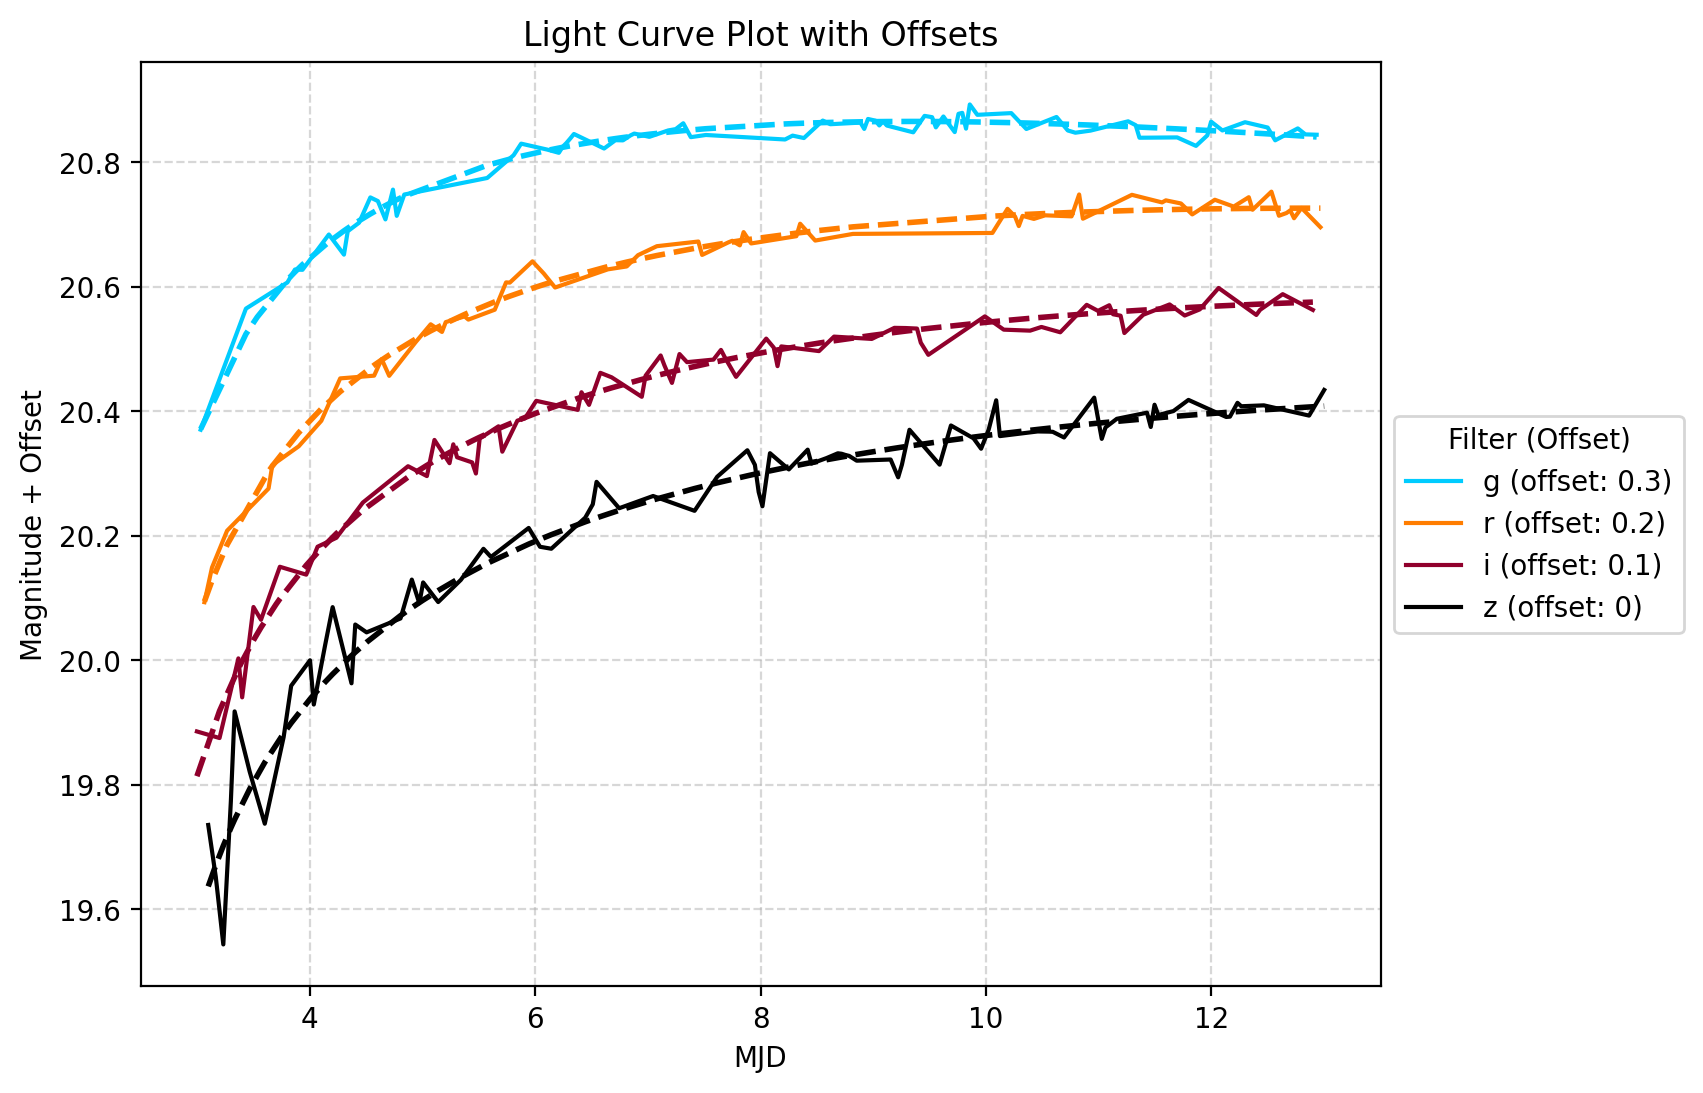

In [36]:
import utils.utils as ut
importlib.reload(ut)

        
# light_curve_plot(lc)
ut.pilca_light_curve_plot(lc, offset = .1, pilcas=pilcas, ufilters=np.unique(filter_for_mjd))
# aaaa

In [ ]:
aaaaa

NameError: name 'aaaaa' is not defined

# BNN

In [ ]:
importlib.reload(tp)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)

## regular loss approach

In [ ]:
importlib.reload(tp)

bnn = tp.MultiFilterBNN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=4,
                    hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 5000
n_samples_loss = 10


for epoch in range(epochs):
    optimizer.zero_grad()

    
    outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


KeyboardInterrupt: 

## modified loss approach

In [ ]:
importlib.reload(tp)

bnn = tp.MultiFilterBNN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=4,
                    hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(bnn.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)
y_true = criterion.get_y_true(X_DATA, filters_mask)


epochs = 5000
n_samples_loss = 50

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)
mae =  torch.nn.L1Loss()
# mse =  torch.nn.MSE()
for epoch in range(epochs):
    optimizer.zero_grad()

    
    # outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa]

    outputs_many = torch.stack([bnn().squeeze() for i in range(n_samples_loss)])
    outputs_mean = outputs_many.mean(0)

    y_many = torch.stack([criterion(outputs_many[i], X_DATA, filters_mask) for i in range(n_samples_loss)])
    y_mean = criterion(outputs_mean, X_DATA, filters_mask)#y_many.mean(0)#

    # y_std  = y_many.std(0).clamp(min=1e-6)


    loss_data = (y_true - y_mean)**2 / (2 * y_std**2) + torch.log(y_std)

    # loss = loss_data.mean() + criterion.get_penalty(outputs_mean)
    loss = torch.nn.functional.mse_loss(y_true, y_mean) + criterion.get_penalty(outputs_mean)

    # somar regularizador (ex: prior dos pesos ou física)

    # loss = loss_data + physics_penalty


    # y_fit = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs_mean, loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     2.2174
Envelope mass (M_env):    1.4215
Density factor (f_rho_M): 1.4215
Radius (R):               3.7365
Explosion time (t_exp):   3.8562
Loss:                     0.151833
----------------------------------------


--- Step 100 ---
Shock velocity (v_s):     1.3058
Envelope mass (M_env):    1.6800
Density factor (f_rho_M): 1.6800
Radius (R):               4.4983
Explosion time (t_exp):   2.2997
Loss:                     0.002220
----------------------------------------
--- Step 200 ---
Shock velocity (v_s):     1.4058
Envelope mass (M_env):    1.7189
Density factor (f_rho_M): 1.7189
Radius (R):               3.2692
Explosion time (t_exp):   2.2375
Loss:                     0.001681
----------------------------------------
--- Step 300 ---
Shock velocity (v_s):     1.3720
Envelope mass (M_env):    1.6520
Density factor (f_rho_M): 1.6520
Radius (R):               3.7417
Explosion time (t_exp):   2.3772
Loss:                     0.001042
----------------------------------------
--- Step 400 ---
Shock velocity (v_s):     1.3384
Envelope mass (M_env):    1.6018
Density factor (f_rho_M): 1.6018
Radius (R):               4.3125
Explosion time (t_exp):   2.1595
Loss:                     0.003290
---------

## evaluation

In [ ]:
samples = []
for i in range(1000):
    samples.append(bnn())
samples = torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]

print(samples.shape)


(1000, 4)


In [ ]:
mean, model_inputs


(array([1.34047777, 1.60639424, 3.94900662, 2.50161533]),
 array([1.26491106, 2.        , 4.03506331, 2.5       ]))

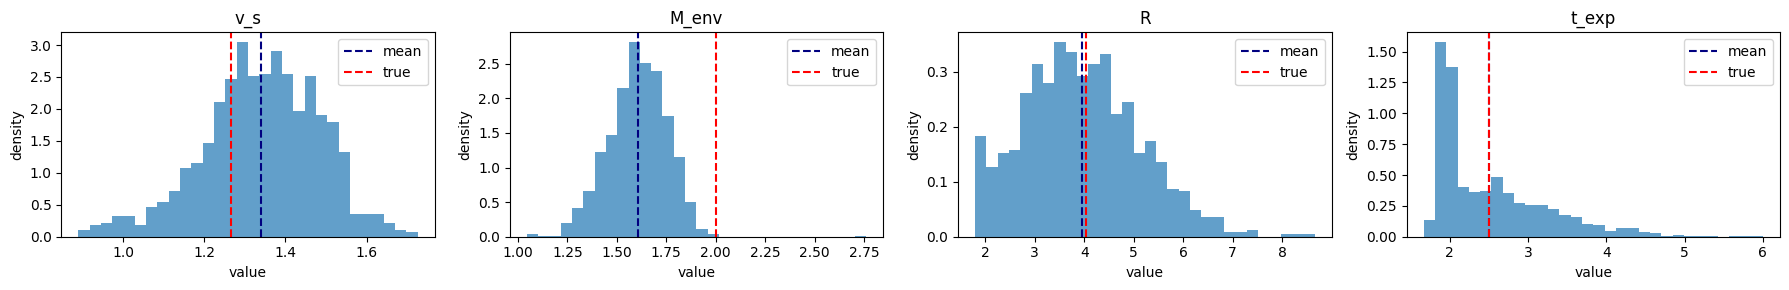

In [ ]:

param_names = ["v_s", "M_env",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = model_inputs
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")

    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

79 79 79
75 75 75
74 74 74
72 72 72
79 79 79
75 75 75
74 74 74
72 72 72


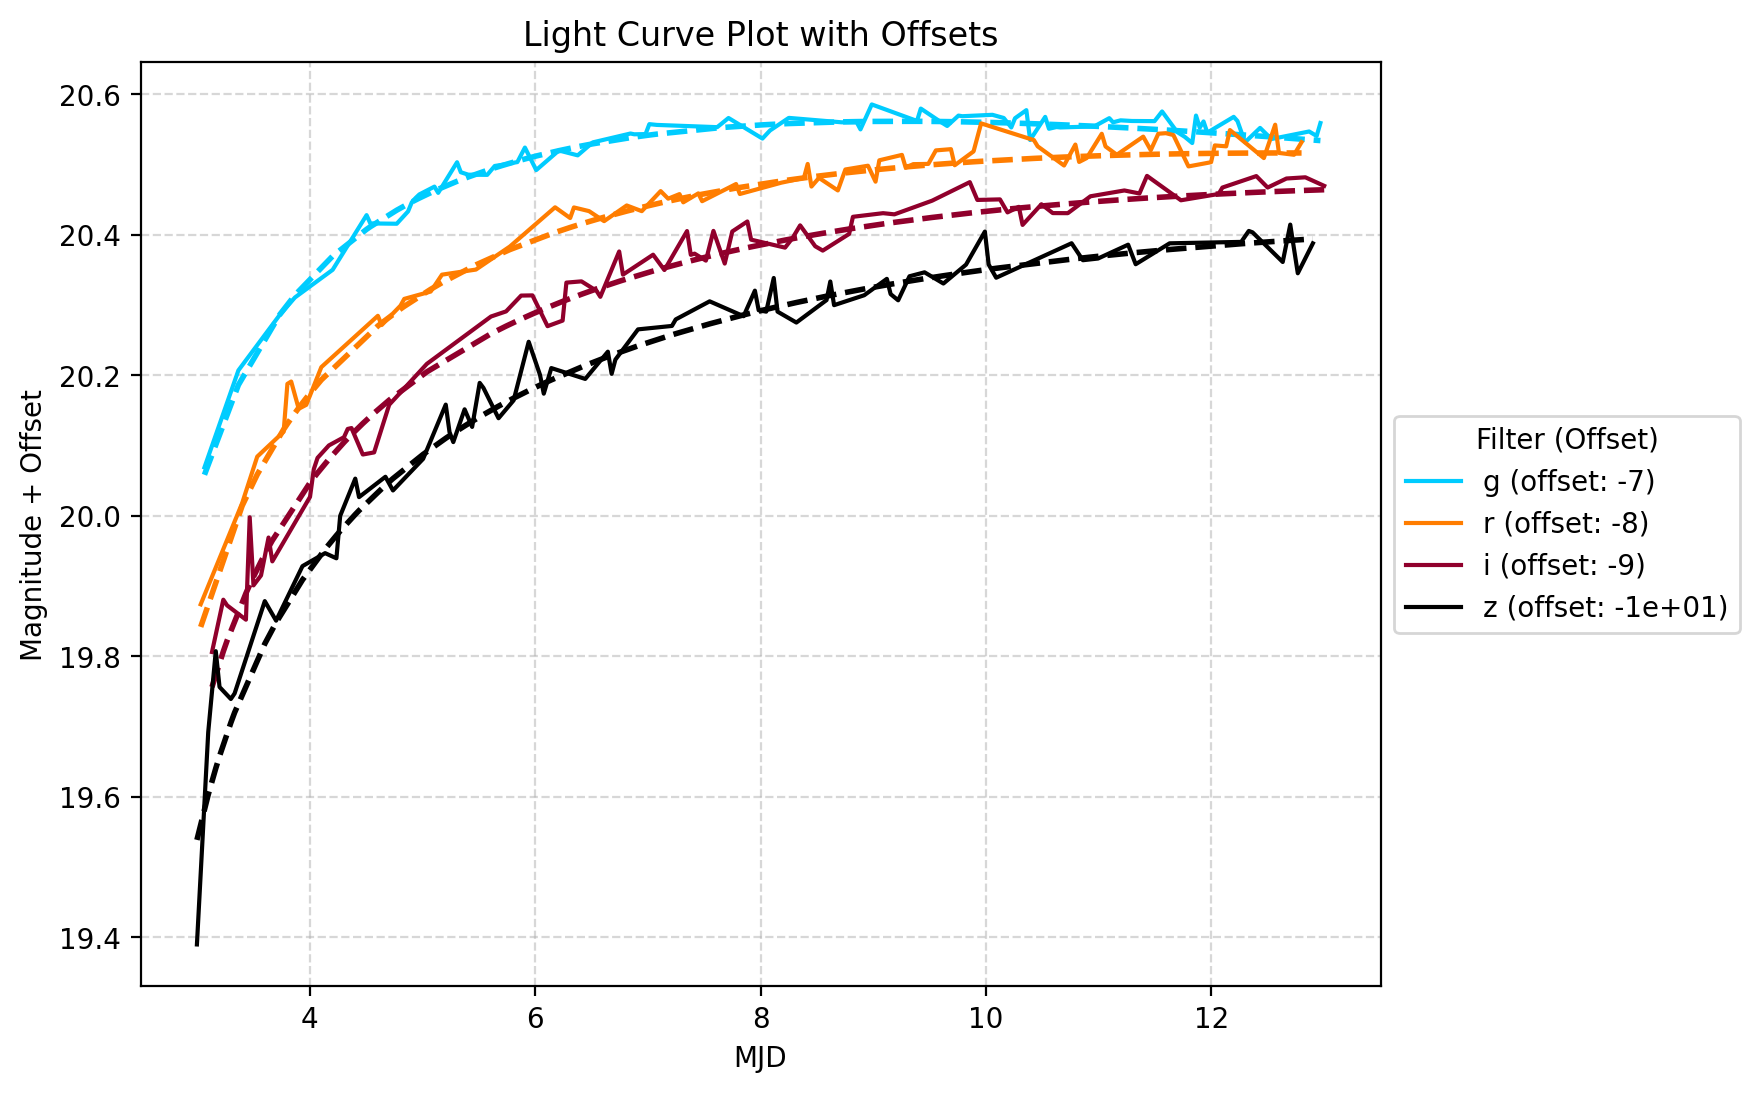

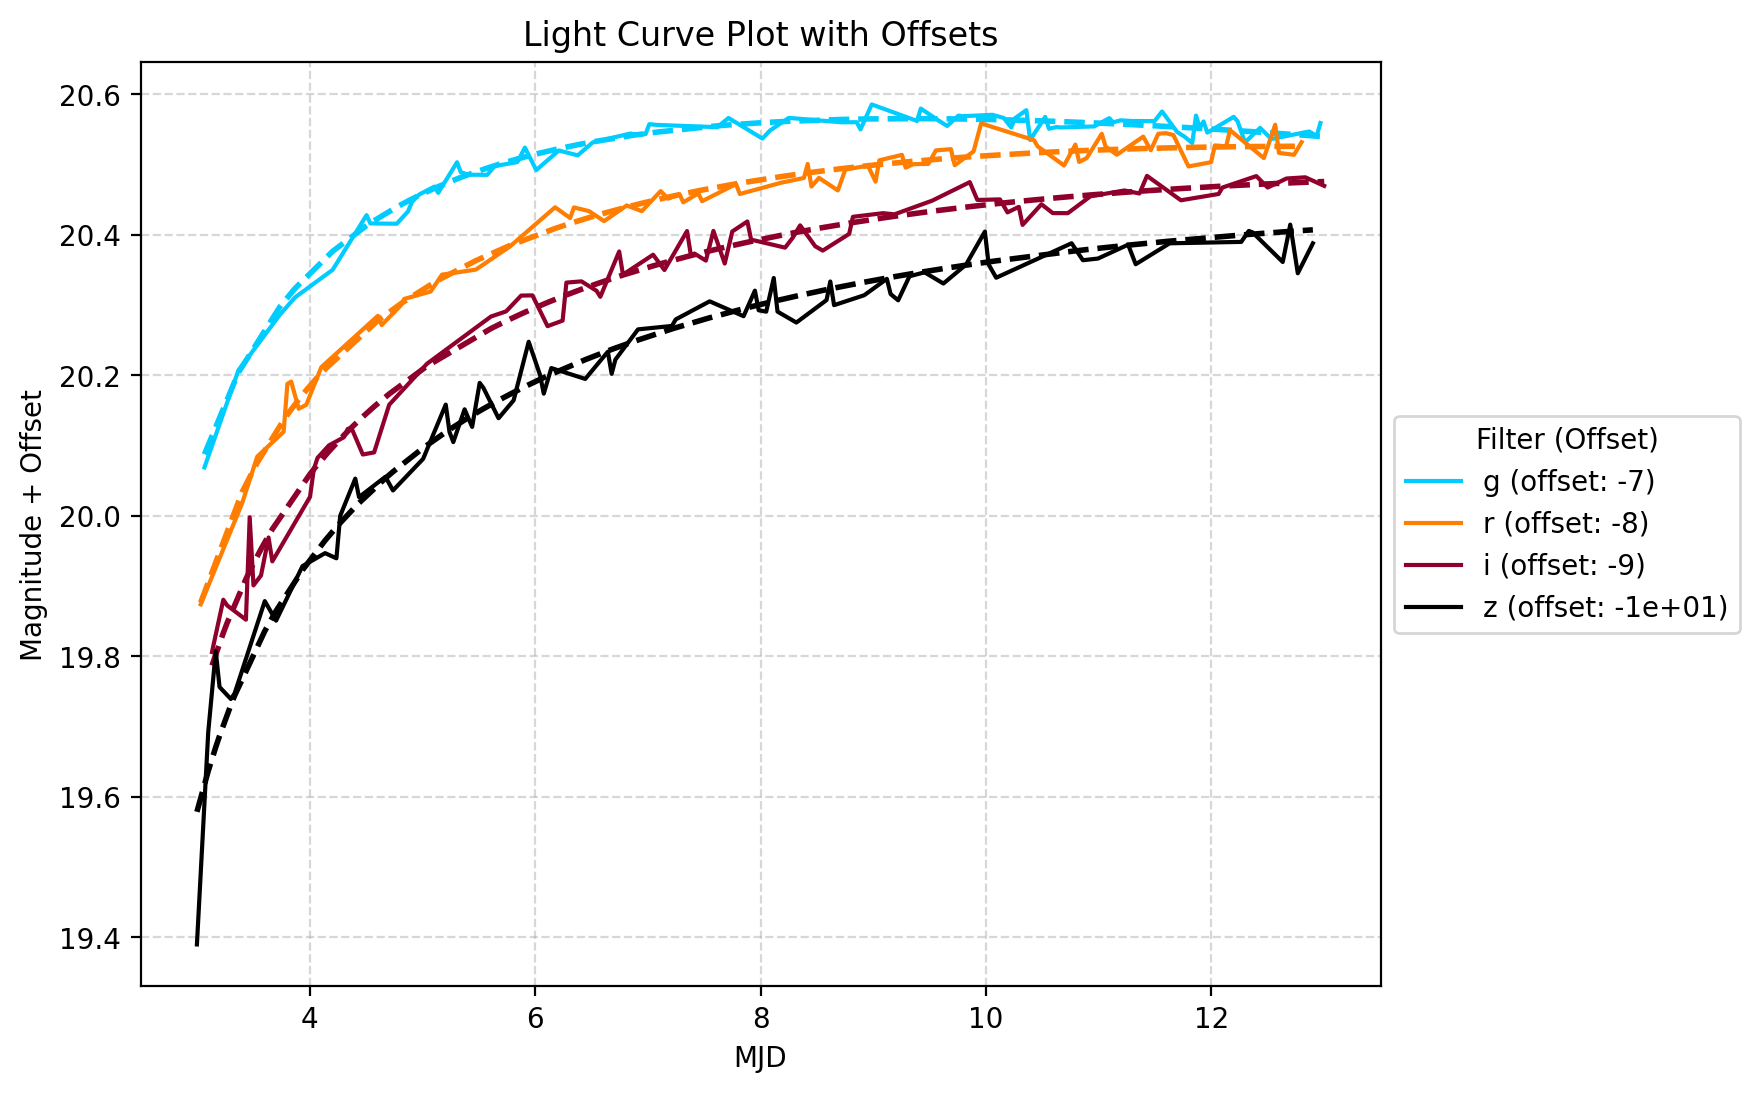

In [ ]:
importlib.reload(ut)
ut.plot_comparison(lc,
                    outputs_mean, filter_for_mjd, MJD, filters_mask)
ut.plot_comparison(lc,
                    model_inputs_torch, filter_for_mjd, MJD, filters_mask)


In [ ]:
a

NameError: name 'a' is not defined

# MDN

In [ ]:
X_DATA.shape, filters_mask.shape

(torch.Size([300, 3]), torch.Size([5, 300]))

In [ ]:
importlib.reload(tp)

mdn = tp.MultiFilterMDN(x_data=X_DATA,
                    filters_mask=filters_mask,
                    param_dim=5,
                    num_components=3,
                    hidden_dim=32)

In [ ]:
mdn.get_params()[1].shape


mdn.get_params()



tensor([0.0629, 0.3767, 0.4119, 0.3053, 0.0922], grad_fn=<AddBackward0>)

In [ ]:
importlib.reload(tp)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1
optimizer = torch.optim.Adam(mdn.parameters(), lr=lr)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
epochs = 20
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = mdn.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa
    loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    if epoch % 1 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs.squeeze(), loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


ValueError: too many values to unpack (expected 4)

0

In [ ]:
for p in mdn.parameters(): 
    print(p.grad.abs().mean())

tensor(53.5003)
tensor(5.6190)
tensor(42.8264)
tensor(32.3367)
tensor(75.9660)
tensor(8.0848)
tensor(71.6435)
tensor(33.3304)
tensor(197.5081)
tensor(20.9123)
tensor(151.1851)
tensor(45.4060)
tensor(118.1536)
tensor(12.7837)
tensor(72.7717)
tensor(26.9660)
tensor(102.9334)
tensor(11.0119)
tensor(123.0183)
tensor(46.4581)
tensor(231.2423)
tensor(182.9379)
tensor(102.0486)
tensor(178.0926)
tensor(190.6379)
tensor(332.6963)


AttributeError: 'NoneType' object has no attribute 'abs'

# Normalizing Flows

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from nflows.flows import Flow
from nflows.transforms import MaskedAffineAutoregressiveTransform
from nflows.distributions import StandardNormal
torch.autograd.set_detect_anomaly(True)
from nflows.transforms import CompositeTransform, Sigmoid, AffineTransform, LeakyReLU, Tanh
from nflows.transforms.base import Transform

p_low, p_high = 0, 10
param_dim = 4
k_layers = 2

layers = []



for i in range(k_layers):
    layers+=[MaskedAffineAutoregressiveTransform(features=param_dim, hidden_features=32),] 
    

flow = Flow(
    CompositeTransform(layers),
    StandardNormal([param_dim])
)

flow = flow.double()

## loss from bnn

In [ ]:
importlib.reload(tp)

# bnn = tp.MultiFilterBNN(x_data=X_DATA,
#                     filters_mask=filters_mask,
#                     param_dim=4,
#                     hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-4
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.5)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)
y_true = criterion.get_y_true(X_DATA, filters_mask)


epochs = 1000
n_samples_loss = 10

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)
mae =  torch.nn.L1Loss()
# mse =  torch.nn.MSE()
for epoch in range(epochs):
    optimizer.zero_grad()

    
    # outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa]

    outputs_many = flow.sample(n_samples_loss)#torch.stack([flow.sample(1).squeeze() for i in range(n_samples_loss)])
    outputs_mean = outputs_many.mean(0).squeeze()
    
    # y_many = torch.stack([criterion(outputs_many[i], X_DATA, filters_mask) for i in range(n_samples_loss)])
    y_mean = criterion(outputs_mean, X_DATA, filters_mask)#y_many.mean(0)#

    # y_std  = y_many.std(0).clamp(min=1e-6)


    # loss_data = (y_true - y_mean)**2 / (2 * y_std**2) + torch.log(y_std)

    # loss = loss_data.mean() + criterion.get_penalty(outputs_mean)
    loss = torch.nn.functional.mse_loss(y_true, y_mean) + criterion.get_penalty(outputs_mean)

    # somar regularizador (ex: prior dos pesos ou física)

    # loss = loss_data + physics_penalty


    # y_fit = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 10 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs_mean, loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     0.9430
Envelope mass (M_env):    0.4534
Density factor (f_rho_M): 0.4534
Radius (R):               3.1483
Explosion time (t_exp):   3.0227
Loss:                     0.286530
----------------------------------------
--- Step 10 ---
Shock velocity (v_s):     0.5369
Envelope mass (M_env):    1.7302
Density factor (f_rho_M): 1.7302
Radius (R):               6.7311
Explosion time (t_exp):   8.6508
Loss:                     0.216359
----------------------------------------
--- Step 20 ---
Shock velocity (v_s):     1.0998
Envelope mass (M_env):    0.0509
Density factor (f_rho_M): 0.0509
Radius (R):               9.1568
Explosion time (t_exp):   7.7942
Loss:                     0.357672
----------------------------------------
--- Step 30 ---
Shock velocity (v_s):     0.0712
Envelope mass (M_env):    -0.1313
Density factor (f_rho_M): -0.1313
Radius (R):               8.8838
Explosion time (t_exp):   5.6799
Loss:                     1.437448
------------

In [ ]:
# samples = []
# for i in range(1000):
#     samples.append(bnn())
samples = flow.sample(1000).detach().cpu().numpy()#torch.stack(samples).detach().cpu().numpy() # shape [N_samples, 5]


print(samples.shape)


(1000, 4)


In [ ]:
mean, model_inputs


(array([1.34047777, 1.60639424, 3.94900662, 2.50161533]),
 array([1.26491106, 2.        , 4.03506331, 2.5       ]))

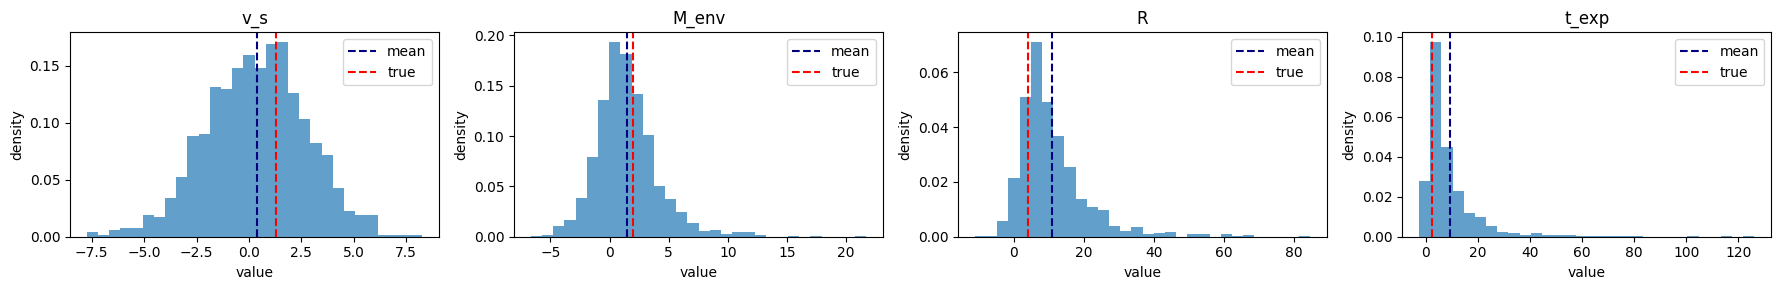

In [ ]:

param_names = ["v_s", "M_env",  "R", "t_exp"]
mean = samples.mean(0)
std = samples.std(0)
true = model_inputs
fig, axes = plt.subplots(1, 4, figsize=(18, 3))
for i, name in enumerate(param_names):
    axes[i].hist(samples[:, i], bins=30, density=True, color="tab:blue", alpha=0.7)
    axes[i].axvline(mean[i], color="navy", linestyle="--", label="mean")
    axes[i].axvline(true[i], color="red", linestyle="--", label="true")

    axes[i].set_title(name)
    axes[i].set_xlabel("value")
    axes[i].set_ylabel("density")
    axes[i].legend()

plt.tight_layout()
plt.show()

80 80 80
68 68 68
69 69 69
83 83 83
80 80 80
68 68 68
69 69 69
83 83 83


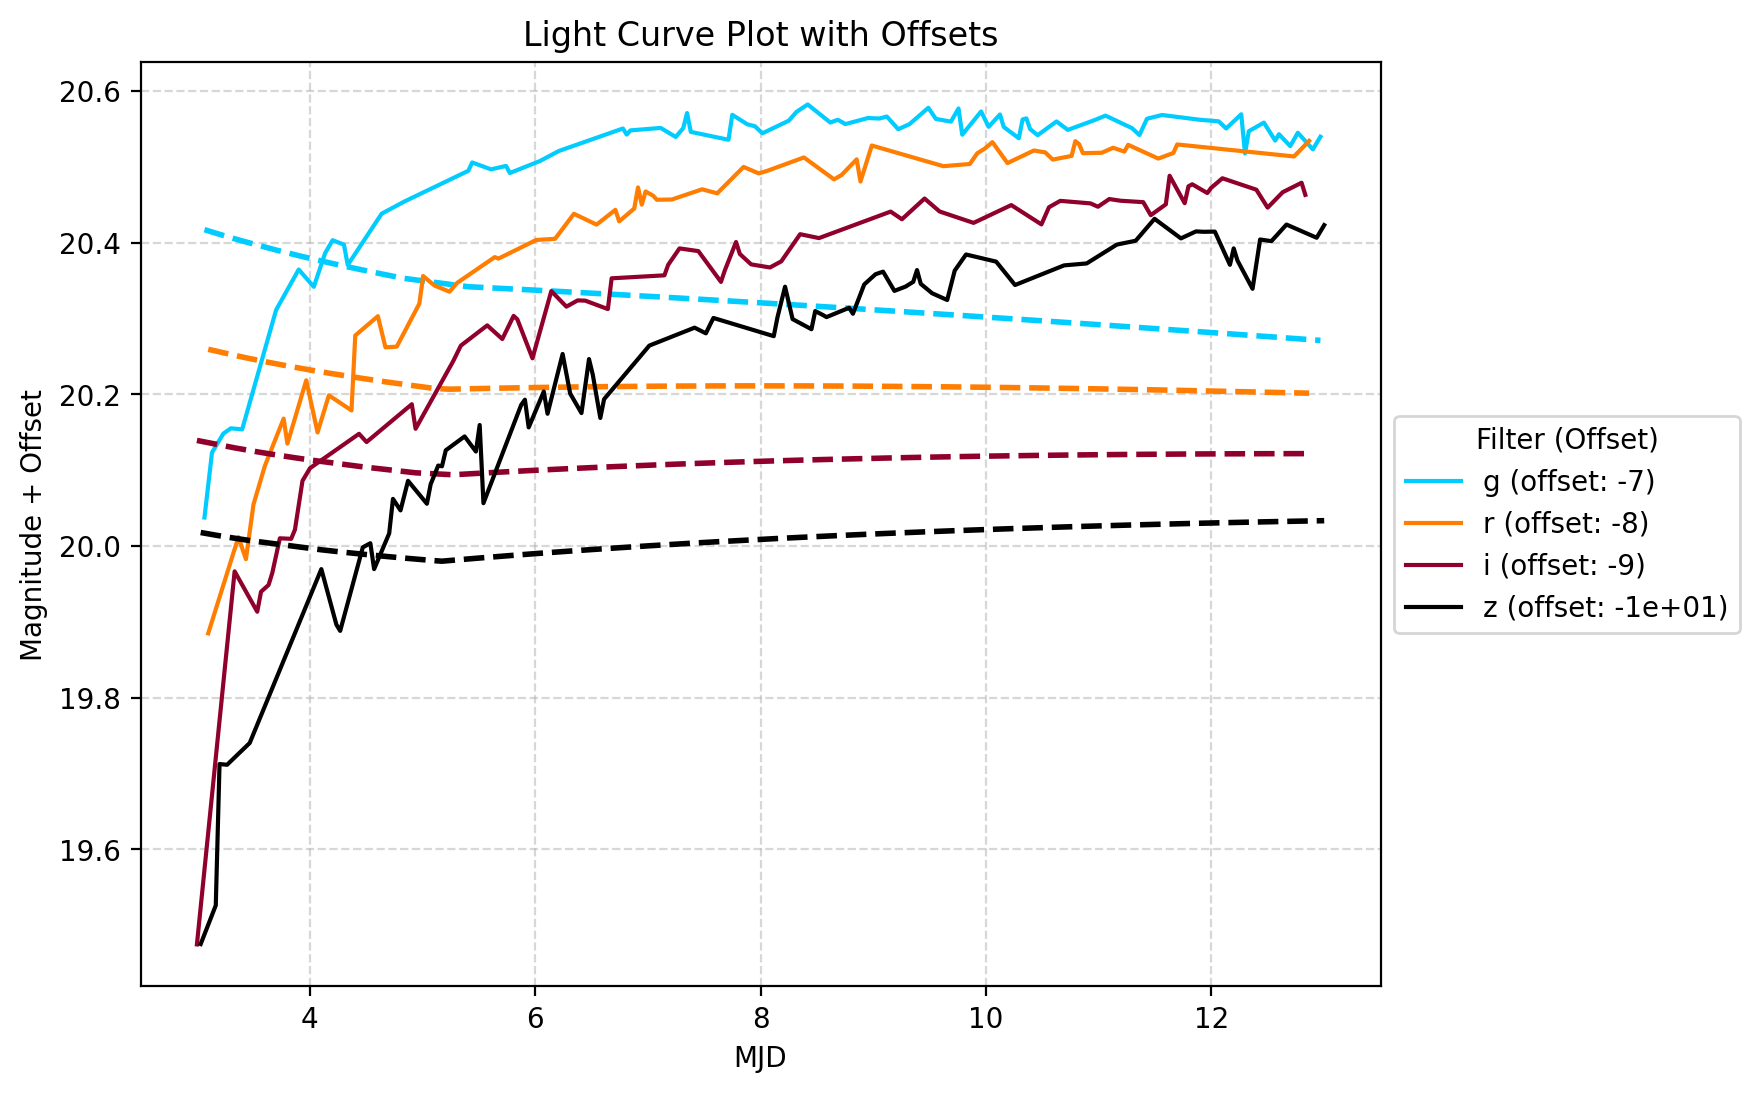

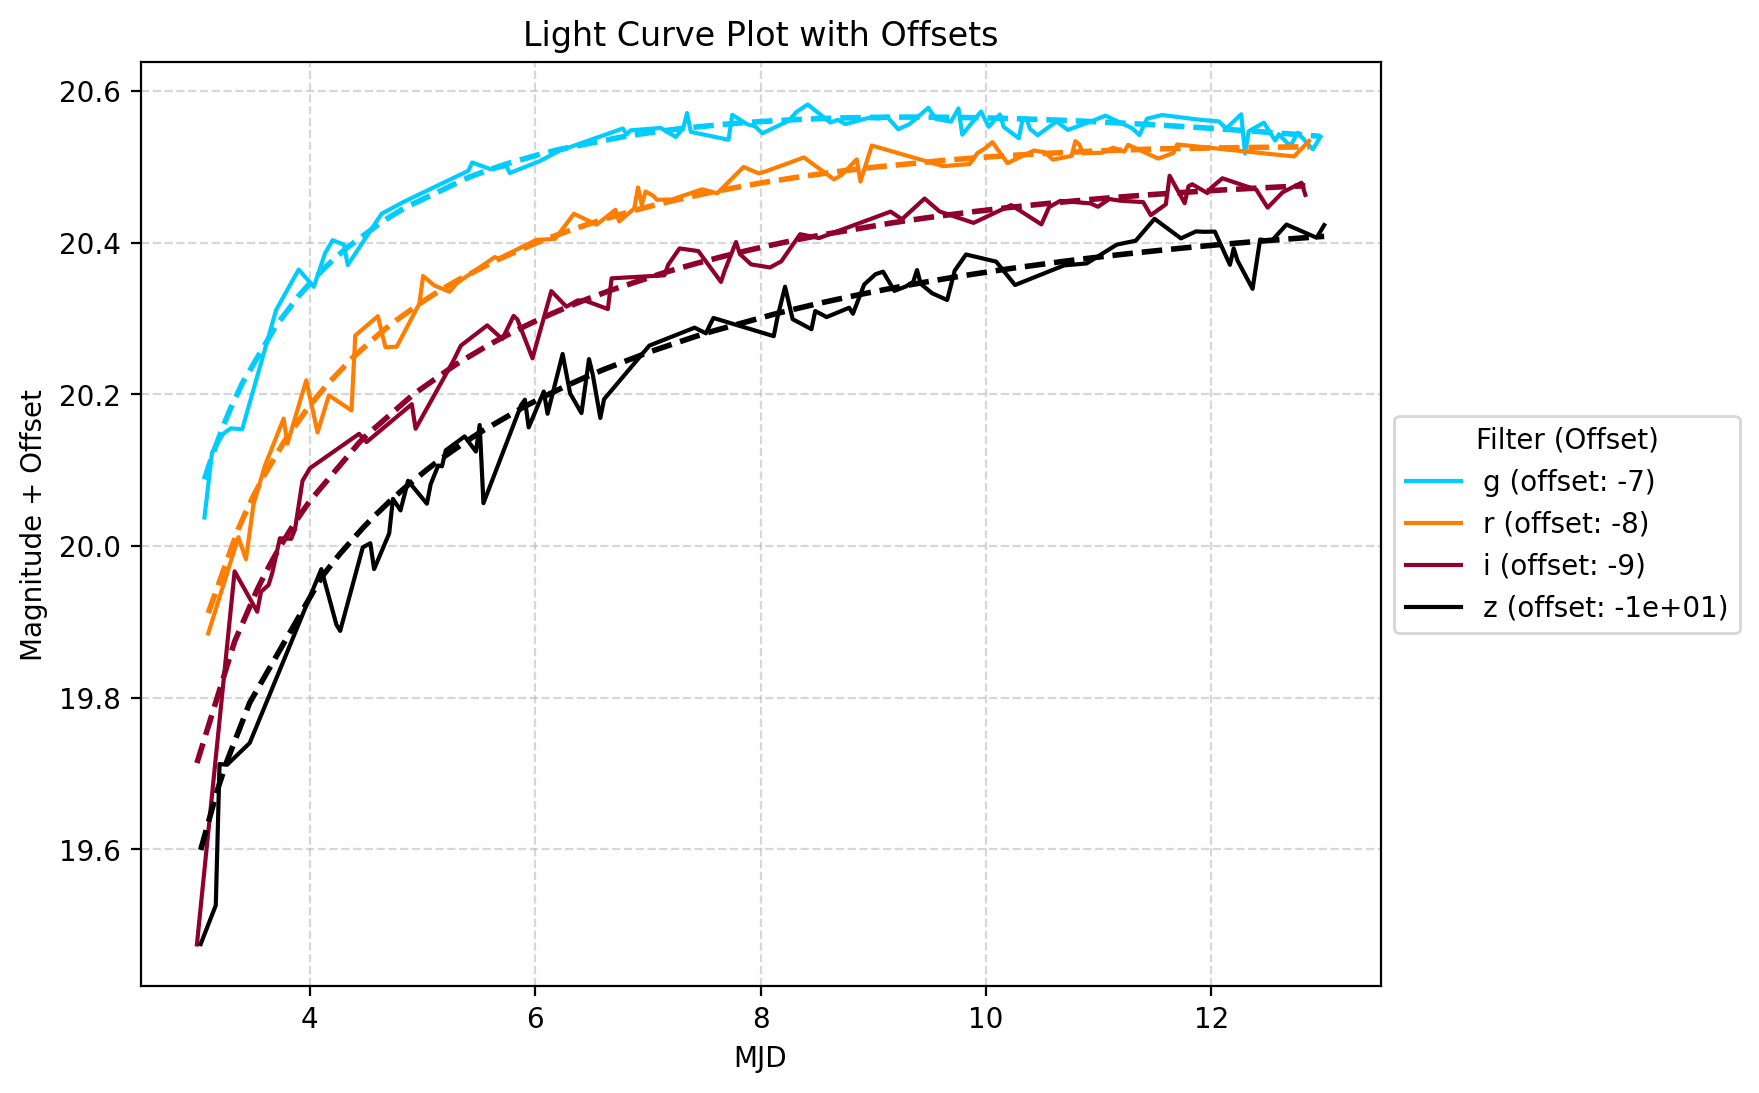

In [ ]:
importlib.reload(ut)
ut.plot_comparison(lc,
                    outputs_mean, filter_for_mjd, MJD, filters_mask)
ut.plot_comparison(lc,
                    model_inputs_torch, filter_for_mjd, MJD, filters_mask)


In [ ]:
outputs_mean


tensor([ 0.0262,  1.6263, -1.7299, -2.0418], grad_fn=<MeanBackward1>)

## original flow loss

In [ ]:
# importlib.reload(tp)

# # model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
# lr=1e-1
# optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
# sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
# criterion = tp.SC4Loss(sc4model, ufilters=ufilters)
# epochs = 3000
# n_samples_loss = 10

# def hard_loss(y_pred, y_true):

#     return torch.mean((y_pred - y_true)**2)

# for epoch in range(epochs):
#     optimizer.zero_grad()
#     outputs = flow.sample(num_samples=1)
#     outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
#     # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
#     # print(outputs)
#     # aaa
#     loss = criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss

#     # for i in range(n_samples_loss-1):
#     #     outputs = flow.sample(1)
#     #     # print(outputs)
#     #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
#     #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
#     #     print(loss)
#     #     # aa

#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         with torch.no_grad():
#             tp.print_outputs(outputs.squeeze(), loss, epoch)
#         # print(outputs)
#         # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     4.9955
Envelope mass (M_env):    4.9942
Density factor (f_rho_M): 4.9997
Radius (R):               5.0009
Explosion time (t_exp):   5.0041
Loss:                     0.849724
----------------------------------------


/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in MulBackward0. Traceback of forward call that caused the error:
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File "/us

RuntimeError: Function 'MulBackward0' returned nan values in its 0th output.

## loss from bnn

In [ ]:
importlib.reload(tp)

# bnn = tp.MultiFilterBNN(x_data=X_DATA,
#                     filters_mask=filters_mask,
#                     param_dim=4,
#                     hidden_dim=32)

# model_inputs_torch = torch.tensor([7.2, 5, 1.6, 410, 2.5])/units_array
lr=1e-3
optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.5)
sc4model = tp.ShockCooling4(z=lc.meta["redshift"])
criterion = tp.ModifiedSC4Loss(sc4model, ufilters=ufilters)
y_true = criterion.get_y_true(X_DATA, filters_mask)


epochs = 5000
n_samples_loss = 50

def hard_loss(y_pred, y_true):

    return torch.mean((y_pred - y_true)**2)
mae =  torch.nn.L1Loss()
# mse =  torch.nn.MSE()
for epoch in range(epochs):
    optimizer.zero_grad()

    
    # outputs = bnn()+1e-4#.get_params()
    # outputs = tp.get_physical(outputs, b=1e-3, low=0, high=10)
    # outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    # print(outputs)
    # aaa]

    outputs_many = torch.stack([flow.sample(1).squeeze() for i in range(n_samples_loss)])
    outputs_mean = outputs_many.mean(0)

    y_many = torch.stack([criterion(outputs_many[i], X_DATA, filters_mask) for i in range(n_samples_loss)])
    y_mean = criterion(outputs_mean, X_DATA, filters_mask)#y_many.mean(0)#

    # y_std  = y_many.std(0).clamp(min=1e-6)


    # loss_data = (y_true - y_mean)**2 / (2 * y_std**2) + torch.log(y_std)

    # loss = loss_data.mean() + criterion.get_penalty(outputs_mean)
    loss = torch.nn.functional.mse_loss(y_true, y_mean) + criterion.get_penalty(outputs_mean)

    # somar regularizador (ex: prior dos pesos ou física)

    # loss = loss_data + physics_penalty


    # y_fit = criterion(outputs.squeeze(), X_DATA, filters_mask)#/n_samples_loss

    

    # for i in range(n_samples_loss-1):
    #     outputs = flow.sample(1)
    #     # print(outputs)
    #     outputs = nn.functional.softplus(outputs).to(torch.float64)#model_inputs_torch#torch.clamp(outputs, 1)
    #     loss += criterion(outputs.squeeze(), X_DATA, filters_mask)/n_samples_loss
    #     print(loss)
    #     # aa

    loss.backward()
    optimizer.step()
    scheduler.step()
    if epoch % 100 == 0:
        # with torch.no_grad():
        tp.print_outputs(outputs_mean, loss, epoch)
        # print(outputs)
        # print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


--- Step 0 ---
Shock velocity (v_s):     0.2538
Envelope mass (M_env):    0.3350
Density factor (f_rho_M): 0.3350
Radius (R):               0.2725
Explosion time (t_exp):   -0.0271
Loss:                     5.549777
----------------------------------------


/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Error detected in MseLossBackward0. Traceback of forward call that caused the error:
  File "/usr/local/lib/python3.10/runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/local/lib/python3.10/runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/usr/local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 712, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
    self._run_once()
  File 

RuntimeError: Function 'MseLossBackward0' returned nan values in its 1th output.

In [ ]:
print(model_inputs)

[1.26491106 2.         0.21       4.03506331 2.5       ]


In [ ]:
model_inputs_torch
a = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)

In [ ]:
a, model_inputs_torch

(tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]),
 tensor([1.2649, 2.0000, 0.2100, 4.0351, 2.5000]))

In [ ]:

model_inputs_torch = torch.tensor([1.26491106, 2., 0.21, 4.03506331, 2.5]).to(torch.float64)#outputs.squeeze()#torch.tensor([]])#/units_array

v_s = model_inputs_torch[0]       # Shock velocity
M_env = model_inputs_torch[1]     # Envelope mass
f_rho_M = model_inputs_torch[2]   # Density profile factor
R = model_inputs_torch[3]         # Radius
t_exp = model_inputs_torch[4]   # explosion time
model = tp.ShockCooling4(z=lc.meta["redshift"])
for f in np.unique(filter_for_mjd):
    mask = filter_for_mjd == f
    y = model(MJD[mask], v_s=v_s, M_env=M_env, f_rho_M=f_rho_M, R=R, t_exp=t_exp, f=f)
    print(y)

##################################


tensor([2.0491e+20, 2.1171e+20, 2.2100e+20, 2.4110e+20, 2.4521e+20, 2.5720e+20,
        2.6810e+20, 2.6994e+20, 2.7895e+20, 2.7923e+20, 2.7948e+20, 2.7970e+20,
        2.8044e+20, 2.8057e+20, 2.8052e+20, 2.7746e+20, 2.7505e+20, 2.7427e+20,
        2.7215e+20, 2.7125e+20, 2.7078e+20, 2.6885e+20, 2.6414e+20, 2.6247e+20,
        2.6190e+20, 2.6025e+20, 2.5882e+20, 2.5314e+20, 2.4618e+20, 2.3144e+20,
        2.2756e+20, 2.2248e+20, 2.1507e+20, 2.1265e+20, 2.0907e+20, 2.0789e+20,
        2.0439e+20, 2.0323e+20, 1.9868e+20, 1.9645e+20, 1.9205e+20, 1.8253e+20,
        1.8150e+20, 1.7448e+20, 1.6494e+20, 1.6401e+20, 1.5859e+20, 1.5683e+20,
        1.4915e+20, 1.4109e+20, 1.3500e+20, 1.3352e+20, 1.2570e+20, 1.2501e+20,
        1.2433e+20, 1.2298e+20, 1.2165e+20, 1.1398e+20, 1.1095e+20, 1.0572e+20,
        1.0348e+20, 1.0130e+20, 1.0076e+20])
tensor([7.1684e+19, 7.4415e+19, 8.2378e+19, 9.2467e+19, 1.1735e+20, 1.2146e+20,
        1.3125e+20, 1.5831e+20, 1.6130e+20, 1.6420e+20, 1.6562e+20, 1.7376e